In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def pseudo_function(x, x_i, n_data):
    n_wave = 5
    exp_max = 1
    exp_min = -1
    bias = 0.5
    a = 1.5
    
    radian_unit = (np.pi * n_wave) / n_data
    exp_unit = (exp_max - exp_min) / n_data 
    
    y = np.sin(x_i*radian_unit)* np.exp(exp_max-(exp_unit*x_i)) + bias + a*x
    
    return y

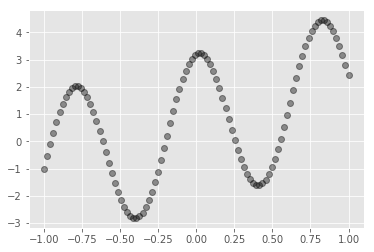

In [3]:
n_data = 100
x_range = (-1, 1)

X_train = np.linspace(-1, 1, n_data,dtype=np.float32)
Y_train = np.array([pseudo_function(x,x_i,n_data) for x_i, x in enumerate(list(X_train))], dtype=np.float32)
plt.cla()
plt.plot(X_train, Y_train, 'ro', alpha=0.4, color='black')

In [4]:
# reshape for model
X_train = np.reshape(X_train, newshape=[-1,1])
Y_train = np.reshape(Y_train, newshape=[-1,1])
print("X_train shape : {}\nY_train shape : {}".format(np.shape(X_train), np.shape(X_train)))

X_train shape : (100, 1)
Y_train shape : (100, 1)


# 2. Make model & Design cost function & optimizer

In [5]:
with tf.variable_scope('variable'):
    X = tf.placeholder(dtype=tf.float32, 
                       shape=[None,1],
                       name="X")
    Y = tf.placeholder(dtype=tf.float32,
                       shape=[None,1],
                       name="Y")
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

In [6]:
def batch_norm_wrapper(X, is_training, decay, name=None):
    """
    Reference : "Batch normalization: Accelerating deep network training by reducing internal covariate shift.", https://arxiv.org/abs/1502.03167
    """
    with tf.variable_scope(name or "batch_nomalization"):
        gamma = tf.Variable(tf.ones([X.get_shape()[-1]]), 
                            trainable=True, 
                            name="gamma")
        beta = tf.Variable(tf.zeros([X.get_shape()[-1]]), 
                           trainable=True, 
                           name="beta")
        
        global_mean = tf.Variable(tf.zeros([X.get_shape()[-1]]), 
                                  trainable=False, 
                                  name="global_mean")
        global_var = tf.Variable(tf.ones([X.get_shape()[-1]]), 
                                 trainable=False,
                                 name="global_var")

        def calc_moments_in_train():
            batch_mean, batch_var = tf.nn.moments(X,[0])
            global_mean_update = tf.assign(global_mean,
                                   global_mean * decay + batch_mean * (1 - decay))
            global_var_update = tf.assign(global_var,
                                  global_var * decay + batch_var * (1 - decay))
            with tf.control_dependencies([global_mean_update, global_var_update]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        def calc_moments_in_predict():
            return global_mean, global_var

        mean, var = tf.cond(is_training, 
                            calc_moments_in_train,
                            calc_moments_in_predict
                           )
    
    return tf.nn.batch_normalization(X, mean, var, beta, gamma, 1e-3)



def flatten(x, name=None):
    with tf.variable_scope('flatten'):
        dims = x.get_shape().as_list()
        if len(dims) == 4:
            flattened = tf.reshape(
                x,
                shape=[-1, dims[1] * dims[2] * dims[3]])
        elif len(dims) == 2 or len(dims) == 1:
            flattened = x
        else:
            raise ValueError('Expected n dimensions of 1, 2 or 4.  Found:',
                             len(dims))

        return flattened

def linear(x, n_output, is_batch_norm=False, is_training=False, name=None, activation=None):
    if len(x.get_shape()) != 2:
        x = flatten(x)

    n_input = x.get_shape().as_list()[1]
    with tf.variable_scope(name or "fc"):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)
        
        if is_batch_norm:
            h = batch_norm_wrapper(h, is_training, decay = 0.5)
        
        if activation:
            h = activation(h)

        return h, W

In [7]:
with tf.variable_scope('mlp_model'):
    # declaration of model
    
    h, _ = linear(X, 16, is_batch_norm=True, is_training=is_training, name="layer_1", activation=tf.nn.relu)
    h, _ = linear(h, 16, is_batch_norm=True, is_training=is_training, name="layer_2", activation=tf.nn.relu)
    Y_pred, _ = linear(h, 1, name="layer_3")
    
    # optimization
    cost = tf.reduce_mean(tf.squared_difference(Y_pred, Y))
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()


# 3. Train & Draw graph¶

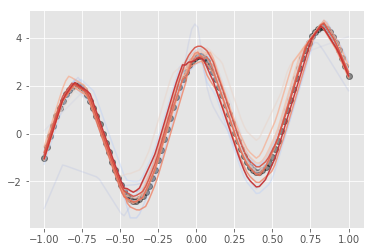

In [20]:
lr = 0.005
n_epoch = 6000

draw_interval = 300
plt.cla()
plt.plot(X_train, Y_train, 'ro', alpha=0.4, label="origin", color="black")

cmap = plt.get_cmap('coolwarm')
c_norm = colors.Normalize(vmin=0, vmax=n_epoch)
scalar_map = cmx.ScalarMappable(norm=c_norm, cmap=cmap)

sess = tf.Session() 
sess.run(init)
for epoch_i in range(n_epoch):
    _ = sess.run(optimizer, feed_dict={X:X_train, 
                                   Y:Y_train, 
                                   learning_rate:lr,
                                   is_training:True,})
    if epoch_i % draw_interval == 0 :
        X_show = X_train.copy()
        Y_show = sess.run(Y_pred, 
                          feed_dict={X:X_show, 
                                     is_training:False,})
        
        plt.plot(X_show, Y_show, alpha=epoch_i/(0.0+n_epoch), color=scalar_map.to_rgba(epoch_i))